In [11]:
1+1

2

In [12]:
from pathlib import Path

is_colab = False  # if run in colab set this true

In [13]:
# setup the environment


if is_colab:

    from google.colab import drive
    drive.mount('/content/gdrive')

    path_root = Path('/content/gdrive/My Drive/Colab Notebooks/')

    # install the pynvcenter package from github
    !pip install git+https://github.com/JanGieseler/pynvcenter.git



    from keras import backend as K
    print(K.tensorflow_backend._get_available_gpus())
else:
    path_root = Path('../')

    # for the local version we assume that pynvcenter is located in the parent dir of the notebook
    import os,sys,inspect
    currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
    parentdir = os.path.dirname(currentdir)
    sys.path.insert(0,parentdir) 

path_ipynb = path_root/'notebooks'
path_data = path_root/'data'
path_model = path_root/'models'
path_html = path_root/'html'

In [103]:
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 

import pynvcenter.nv_analysis as nv_analysis

from sklearn.externals import joblib

import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from keras import optimizers
from sklearn.metrics import mean_squared_error
from keras.callbacks import Callback
from sklearn.externals import joblib
import h5py
from keras import regularizers

from sklearn.model_selection import learning_curve

from keras.callbacks import EarlyStopping, ModelCheckpoint
import time
import json
import matplotlib.pyplot as plt


from matplotlib.patches import Rectangle

%matplotlib inline

from tqdm import tqdm

import h5py
%load_ext autoreload
%autoreload 2
from keras.models import load_model

from glob import glob

import matplotlib 

from IPython.display import display, Markdown

FONT_SIZE = 20
matplotlib.rc('xtick', labelsize=FONT_SIZE) 
matplotlib.rc('ytick', labelsize=FONT_SIZE) 
matplotlib.rc('axes', titlesize=10) 
matplotlib.rc('axes', labelsize=FONT_SIZE) 
matplotlib.rc('lines', linewidth=2) 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
from pynvcenter.nn_utils import *

### show the experimental data
#### define inputs (filenames, calibration, etc.)

##### From 190123

In [5]:
# filename_esr = '../data_exp/190122-15_41_20_esr_many_on_alice_wider_range_center_0_0_esr_map.h5'
# filename_pos = '../data_exp/190122-15_40_40_select_points'


filename_pos = '../data_exp/190123-19_32_44_select_points'

filename_esr = '../data_exp/190123-19_39_47_esr_many_on_alice_wider_range_center_0_0'




freq_center = 2870000000.0
freq_range = 500000000.0


calibration_factor = 200/162 * 267 / 0.5  # mu / px * px / V = mu / V

particle_radius = 19  # um

print('the calibration factor is {:0.3f} micrometers / volt'.format(calibration_factor))

h5f = h5py.File(filename_esr+'_esr_map.h5', 'r')
esr_map = np.array(h5f['esr_map'])
frequencies = np.array(h5f['frequency'])
h5f.close()
print('frequencies from {:0.3f}GHz - {:0.3f}GHz'.format(1e-9*(freq_center-freq_range/2), 1e-9*((freq_center+freq_range/2))))

the calibration factor is 659.259 micrometers / volt
frequencies from 2.620GHz - 3.120GHz


##### From 190125

In [23]:
filename_pos = '../data_exp/190125-21_00_31_select_points'

filenames_esr = [
    '../data_exp/190125-21_01_46_esr_many_on_alice_wider_range_center_0_0',
    '../data_exp/190127-18_08_52_esr_many_on_alice_wider_range_center_0_0'
                ]

freq_center = 2870000000.0
freq_range = 500000000.0


img_dims = [50, 200]

calibration_factor = 200/162 * 267 / 0.5  # mu / px * px / V = mu / V

particle_radius = 19  # um

print('the calibration factor is {:0.3f} micrometers / volt'.format(calibration_factor))

esr_map = None
for filename_esr in filenames_esr:
    print(filename_esr)
    h5f = h5py.File(filename_esr+'_esr_map.h5', 'r')
    
    if esr_map is None:
        esr_map = np.array(h5f['esr_map'])
    else:
        esr_map += np.array(h5f['esr_map'])
    frequencies = np.array(h5f['frequency'])
    h5f.close()
print('frequencies from {:0.3f}GHz - {:0.3f}GHz'.format(1e-9*(freq_center-freq_range/2), 1e-9*((freq_center+freq_range/2))))
esr_map /=len(filenames_esr)

the calibration factor is 659.259 micrometers / volt
../data_exp/190125-21_01_46_esr_many_on_alice_wider_range_center_0_0
../data_exp/190127-18_08_52_esr_many_on_alice_wider_range_center_0_0
frequencies from 2.620GHz - 3.120GHz


In [24]:
# def pad_esr_map(frequencies, angles, esr_map, img_dims):


#     padding_dims = [d-s for s, d in zip(esr_map.shape, img_dims)]
#     print('typically we expect to cut off the image along the frequency dimension and pad it in the angle dimension')
#     assert padding_dims[0]>=0
#     assert padding_dims[1]<=0
#     padding_dims = [[p//2, p-p//2] for p in padding_dims]  # calculate the padding dims for the left/right, up/down
#     padding_dims[1] = [-padding_dims[1][0]-1, esr_map.shape[1]+padding_dims[1][0]] # for the freq we actually want the range
#     esr_map = np.vstack([esr_map[-padding_dims[0][0]:], esr_map, esr_map[0:padding_dims[0][1]]])
#     esr_map = esr_map[:,padding_dims[1][0]:padding_dims[1][1]]
    
#     angles = np.hstack([angles[-padding_dims[0][0]:]-360, angles, 360+angles[0:padding_dims[0][1]]])
#     frequencies = frequencies[padding_dims[1][0]:padding_dims[1][1]]
#     return frequencies, angles, esr_map

# # f, a, e = pad_esr_map(frequencies, angles, esr_map, img_dims)
# # print(e.shape)  
# # plt.pcolor(f, a, e)
# # img_dims[0]//2, img_dims[0]//2

(45, 251)


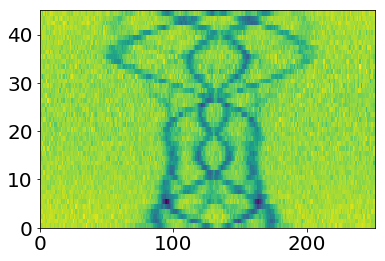

In [210]:
print(esr_map.shape)

plt.pcolor(esr_map)

**esr radius:	 72.433 micrometers**

image dimensions:  (45, 251)


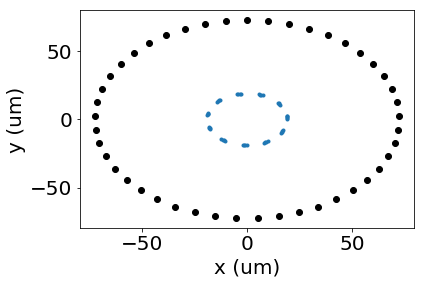

In [26]:
nv_positions = calibration_factor * np.genfromtxt(filename_pos+ '-nv_locations.csv', delimiter=',')[1:]  # positions in um
angles = np.genfromtxt(filename_pos+ '-angles.csv', delimiter=',')[1:]  # angles in rad

nv_positions -=np.mean(nv_positions, axis=0)  # center around zero 
nv_positions, angles = nv_positions[angles.argsort()], angles[angles.argsort()] # sort
for pos in nv_positions:
    plt.plot(pos[0], pos[1], 'ko')
    
# angles = np.linspace(0, 360, esr_map.shape[0])
plt.plot(particle_radius*np.cos(angles), particle_radius*np.sin(angles), '.')

radius  = np.mean(np.sqrt(np.sum(nv_positions**2, axis=1)))
display(Markdown('**esr radius:\t {:0.3f} micrometers**'.format(radius)))
plt.xlabel('x (um)')
plt.ylabel('y (um)')

print('image dimensions: ', esr_map.shape)

In [27]:
noise_region = {'fmin':2.65e9, 'f_range':1e8, 'angle_min':50, 'angle_range':150}

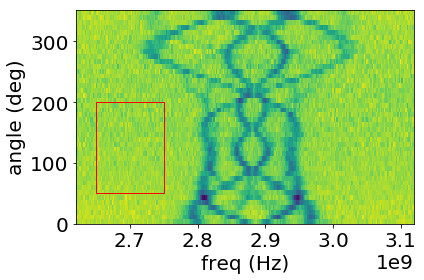

In [28]:
# angles = np.linspace(0, 360, esr_map.shape[0])
fig, ax = plt.subplots(1, 1, figsize=(6, 4))


ax.pcolor(frequencies, angles, esr_map)

# Create a Rectangle patch
rect = Rectangle((noise_region['fmin'],noise_region['angle_min']),
                 noise_region['f_range'],noise_region['angle_range'],linewidth=1,edgecolor='r',facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

ax.set_ylabel('angle (deg)')
ax.set_xlabel('freq (Hz)')
# ax.set_title('theta = {:0.0f}, phi={:0.0f}'.format(theta_mag, phi_mag))
plt.tight_layout()

fig.savefig('190125_esp_map.png')

In [212]:
img_dims = [100,200]

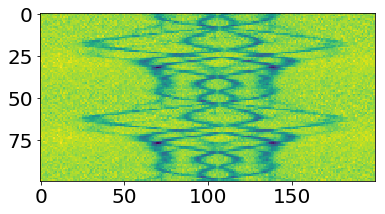

In [218]:
fig=plt.figure()

Xo = pad_image(esr_map, img_dims=img_dims)
Xo.shape

img = Xo-Xo.min()
img = 255 * img / img.max()
img = img.astype(np.uint8)

plt.imshow(img)


imsave('esr_map_2.jpg', img)

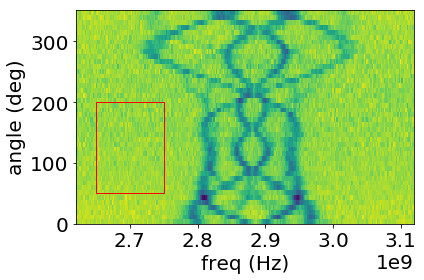

In [29]:
# angles = np.linspace(0, 360, esr_map.shape[0])
fig, ax = plt.subplots(1, 1, figsize=(6, 4))


ax.pcolor(frequencies, angles, esr_map)

# Create a Rectangle patch
rect = Rectangle((noise_region['fmin'],noise_region['angle_min']),
                 noise_region['f_range'],noise_region['angle_range'],linewidth=1,edgecolor='r',facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

ax.set_ylabel('angle (deg)')
ax.set_xlabel('freq (Hz)')
# ax.set_title('theta = {:0.0f}, phi={:0.0f}'.format(theta_mag, phi_mag))
plt.tight_layout()

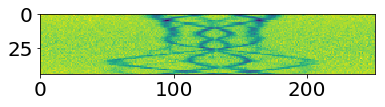

In [30]:
fig = plt.figure()
plt.imshow(esr_map)

### Look at the noise

The noise is $n = \sqrt{c \tau}$, where $s = c \tau$ are the number of photons collected. Thus, the normalized noise is

$$n_{\rm norm} = n/s =  1 / \sqrt{c \tau}$$,

where $c$ is the count rate and $\tau$ the measurement time.

**noise: 0.12%**

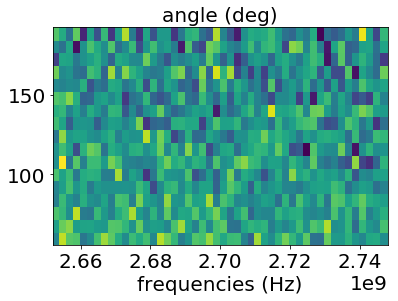

In [31]:
freq_select = np.array(frequencies>noise_region['fmin']) & np.array(frequencies<noise_region['fmin']+noise_region['f_range'])
angle_select = np.array(angles>noise_region['angle_min']) & np.array(angles<noise_region['angle_min']+noise_region['angle_range'])

noise = esr_map[angle_select][:,freq_select]
plt.pcolor(frequencies[freq_select], angles[angle_select], noise)
plt.title('noise')
plt.xlabel('frequencies (Hz)')
plt.title('angle (deg)')
display(Markdown('**noise: {:0.2f}%**'.format(noise.std() / noise.mean() * 100)))


### look at the distributions and get SNR

0.03377057881426171


**SNR: 28**

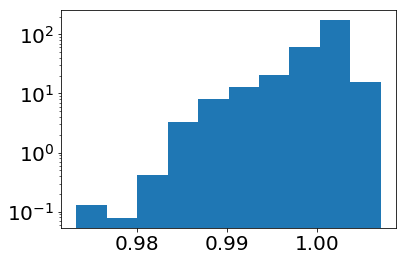

In [32]:
signal = esr_map.max() - esr_map.min()
print(signal)
display(Markdown('**SNR: {:0.0f}**'.format(signal / noise.std())))
plt.hist(esr_map.flatten(), density=True, log=True);

**show available models**

In [33]:
# [f.split('/')[-1].split('_model.h5')[0] for f in glob('../models/*model*.h5')]
list(path_model.glob('*_model*'))

[PosixPath('../models/20190201-1943_sim_data_2_model.h5'),
 PosixPath('../models/20190201-2341_sim_data_3_model.h5'),
 PosixPath('../models/shot_noise_0_xyztp_model.h5'),
 PosixPath('../models/20190131-1725_sim_data_20190125_model.h5'),
 PosixPath('../models/20190201-0031_sim_data_20190125_model.h5'),
 PosixPath('../models/20190201-2336_sim_data_3_model.h5'),
 PosixPath('../models/20190203-2346_sim_data_4_model.h5')]

## load the model

In [183]:
model_name = '20190203-2346_sim_data_4_model.h5'
model_name = '20190201-2341_sim_data_3_model.h5'

In [184]:
import keras
print(keras.__version__)
model = load_model(str(path_model/model_name))
# keras.models.load_model(str(path_model/model_name)) 
model.summary()

2.2.4
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 48, 198, 64)       576       
_________________________________________________________________
batch_normalization_1 (Batch (None, 48, 198, 64)       256       
_________________________________________________________________
activation_8 (Activation)    (None, 48, 198, 64)       0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 24, 99, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 22, 97, 128)       73728     
_________________________________________________________________
batch_normalization_2 (Batch (None, 22, 97, 128)       512       
_________________________________________________________________
activation_9 (Activation)    (None, 22, 97, 128)       0         
____

In [185]:
# load the scaler
# x_scaler = joblib.load(str(path_model/model_name).replace('_model.h5', '_x_scaler.save'))  
y_scaler = joblib.load(str(path_model/model_name).replace('_model.h5', '_y_scaler.save')) 

In [186]:
# load the labels
# with open(str(path_model/model_name).replace('_model.h5', '_labels.txt'),"r") as filein:
with open(str(path_model/model_name).replace('_model.h5', '_labels_Y.txt'),"r") as filein:
    labels_Y = filein.read().split(',')
labels_Y

['particle_radius',
 'nv_radius',
 'theta_mag',
 'phi_mag',
 'dipole_height',
 'xo',
 'yo']

In [188]:
filename = 'sim_data_3_--type--_000'

filename.replace('--type--', 'parameters')

'sim_data_3_parameters_000'

In [189]:
# load the magnet parameters
with open(path_data/(filename.replace('--type--', 'parameters')+'.json'), 'r') as infile:
    magnet_parameters =  json.load(infile)
magnet_parameters

labels = [k for k, v in magnet_parameters.items() if type(v) in (list, tuple)]
len(labels), labels

(10,
 ['particle_radius',
  'nv_radius',
  'theta_mag',
  'phi_mag',
  'dipole_height',
  'linewidth',
  'xo',
  'yo',
  'MW_rabi',
  'Dgs'])

In [219]:
labels_Y

['particle_radius',
 'nv_radius',
 'theta_mag',
 'phi_mag',
 'dipole_height',
 'xo',
 'yo']

In [190]:
magnet_parameters

{'particle_radius': [16, 8],
 'nv_radius': [72, 4],
 'theta_mag': [45, 90],
 'phi_mag': [45, 90],
 'dipole_height': [55, 60],
 'shot_noise': 0,
 'linewidth': [10000000.0, 5000000.0],
 'n_angle': 45,
 'n_freq': 200,
 'f_min': 2670000000.0,
 'f_max': 3068000000.0,
 'avrg_count_rate': 1,
 'xo': [0, 3],
 'yo': [0, 3],
 'MW_rabi': [2, 3],
 'Dgs': [2.87, 0.01]}

### show how well model fits on simulated data

In [191]:
# magnet_parameters = {
#     'particle_radius': (19,1),
#     'nv_radius': (67,1),
#     'theta_mag': 0,
#     'phi_mag': 60,
#     'dipole_height': 80,
#     'shot_noise': 0,
#     'linewidth': 10000000.0,
#     'n_angle': 48,
#     'n_freq': 448,
#     'f_min': 2620000000.0,
#     'f_max': 3120000000.0,
#     'avrg_count_rate': 1,
#     'xo': 0,
#     'yo': 0}

In [192]:
n_max = 5

# magnet_parameters_new = {**magnet_parameters, 'particle_radius': 18}

print('genrate validation set')
val_set = generate_data(n_max, n_jobs=3, parameters=magnet_parameters)


noise = 0.005*np.random.randn(*val_set['X'].shape)
Xo = val_set['X'][0:n_max]+noise
Yo = val_set['Y']

Xo = esr_preprocessing(Xo)

Xo = pad_image(Xo, img_dims=img_dims)

Yo = Yo[:,[k in labels_Y for k in labels]]

print(Xo.min(), Xo.max())

  0%|          | 0/5 [00:00<?, ?it/s]

genrate validation set


100%|██████████| 5/5 [00:00<00:00, 14.62it/s]


-0.2372407903456413 0.8812583310955828


In [193]:
Xo.shape, Yo.shape, len(labels), len(labels_Y), n_max

((5, 50, 200), (5, 7), 10, 7, 5)

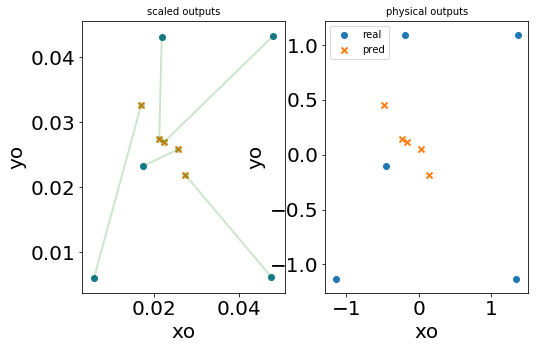

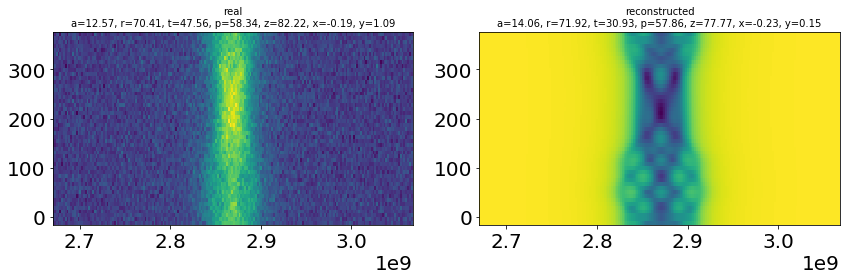

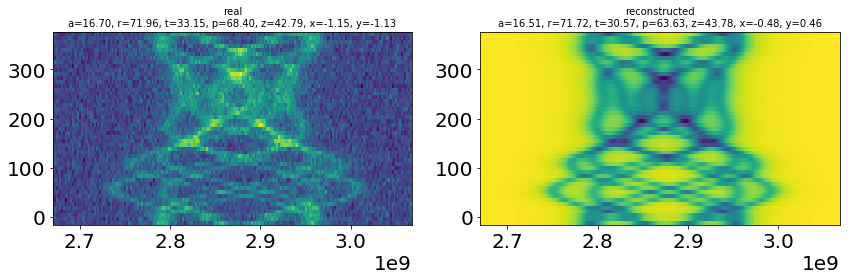

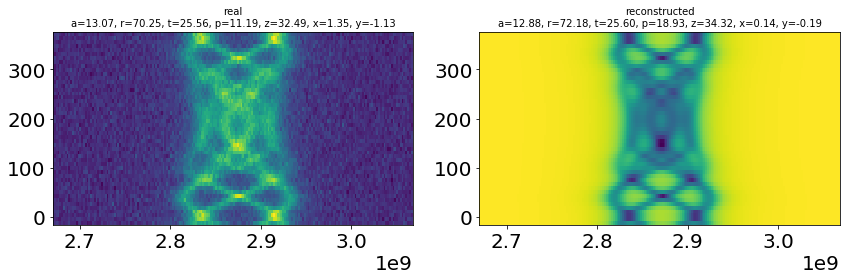

In [194]:
analyze_fit(Xo, Yo, model=model, labels=labels, labels_Y=labels_Y,
            magnet_parameters=magnet_parameters, n_max = n_max,
            x_scaler=None, y_scaler=y_scaler)

### make prediction for the data - dataset from

In [195]:
img_dims

[50, 200]

(-0.18457531669368593, 0.7898559009711881, (50, 200))

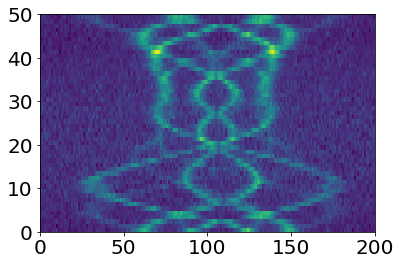

In [196]:
Xo = esr_preprocessing(np.expand_dims(esr_map, axis=0))
Xo = np.flip(Xo, axis=1)  # flip the image upside down

Xo = pad_image(Xo, img_dims)
plt.pcolor(Xo[0])
Xo[0].min(), Xo[0].max(), Xo[0].shape

In [197]:
from imageio import imsave
img = Xo[0]-Xo.min()
img = 255 * img / img.max()
img = img.astype(np.uint8)

# import scipy.misc

imsave('esr_map.jpg', img)

In [198]:
esr_y_pred = model.predict(np.expand_dims(Xo, axis=-1))
esr_y_pred

array([[0.07394011, 0.03718178, 0.522994  , 0.43028924, 0.37328666,
        0.02028883, 0.02299581]], dtype=float32)

In [199]:
esr_y_pred_real = y_scaler.inverse_transform(esr_y_pred, inplace=False)[0]

In [200]:
pd.DataFrame(np.expand_dims(esr_y_pred_real, axis=0), columns=labels_Y)

,particle_radius,nv_radius,theta_mag,phi_mag,dipole_height,xo,yo
0,16.436407,72.230904,47.069458,38.726032,47.397202,-0.28267,-0.120251


In [169]:
pd.DataFrame(np.expand_dims(esr_y_pred_real, axis=0), columns=labels_Y)

,particle_radius,nv_radius,theta_mag,phi_mag,dipole_height,xo,yo
0,14.29173,72.065125,1.158435,63.95525,58.855934,-0.055692,0.383874


In [135]:
# magnet_parameters={'particle_radius': [18, 4],
#  'nv_radius': 72.433,
#  'theta_mag': [45, 90],
#  'phi_mag': [45, 90],
#  'dipole_height': [70, 20],
#  'shot_noise': 0,
#  'linewidth': 14000000.0,
#  'n_angle': 45,
#  'n_freq': 200,
#  'f_min': 2670000000.0,
#  'f_max': 3068000000.0,
#  'avrg_count_rate': 1,
#  'xo': [0, 3],
#  'yo': [0, 3]}

In [179]:
# 


In [201]:
magnet_parameters_new = {**magnet_parameters, **{k:v for k, v in zip(labels_Y,esr_y_pred_real)}}
# if magnet_parameters_new contains ranges we take the first value which corresponds to the center of the range
# in the future we might provide an option to change this behaviour
magnet_parameters_new = {**magnet_parameters_new,
                         **{k: v[0] for k, v in magnet_parameters_new.items() if type(v) in (list, tuple)}}
magnet_parameters_new

{'particle_radius': 16.436407,
 'nv_radius': 72.2309,
 'theta_mag': 47.069458,
 'phi_mag': 38.726032,
 'dipole_height': 47.3972,
 'shot_noise': 0,
 'linewidth': 10000000.0,
 'n_angle': 45,
 'n_freq': 200,
 'f_min': 2670000000.0,
 'f_max': 3068000000.0,
 'avrg_count_rate': 1,
 'xo': -0.2826705,
 'yo': -0.12025118,
 'MW_rabi': 2,
 'Dgs': 2.87}

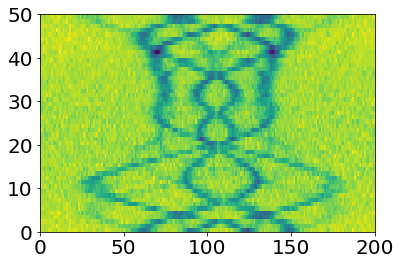

In [209]:
img_exp = np.squeeze(Xo[0])
img_exp -= img_exp.min()
img_exp /= img_exp.max()
img_exp = 1-img_exp

img_exp.min(), img_exp.max()

plt.pcolor(img_exp)

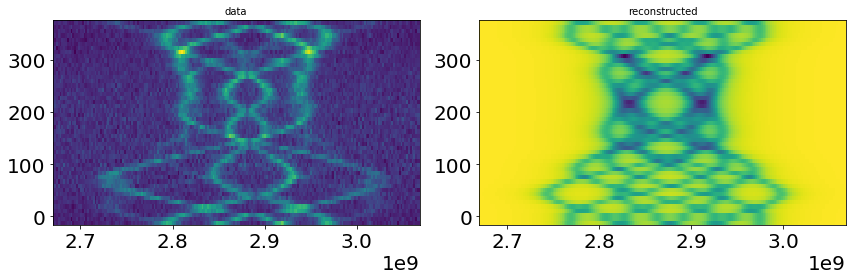

In [203]:
f_min = magnet_parameters['f_min']
f_max = magnet_parameters['f_max']
n_angle = magnet_parameters['n_angle']
n_freq = magnet_parameters['n_freq']
frequencies = np.linspace(f_min, f_max, n_freq)
angle = np.linspace(0, 360, n_angle+1)[0:-1]


fig, ax = plt.subplots(1, 2, figsize=(12, 4))

# and create the image, construction in second argument constructs the updates parameter dictionary
img = create_image(**magnet_parameters_new)

img, angle, frequencies = pad_image(img, img_dims, angles=angle, frequencies=frequencies)


ax[0].pcolor(frequencies, angle, np.squeeze(Xo[0]))
ax[0].set_title('data')
ax[1].pcolor(frequencies, angle, img)
ax[1].set_title('reconstructed')
# ax[1].set_title(
#     'reconstructed\n' + ', '.join([label_map[k] + '={:0.2f}' for k in labels]).format(*esr_y_pred_real[0]))
plt.tight_layout()

In [146]:
img

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])

{'particle_radius': 16.436407,
 'nv_radius': 72.2309,
 'theta_mag': 47.069458,
 'phi_mag': 38.726032,
 'dipole_height': 47.3972,
 'shot_noise': 0,
 'linewidth': 10000000.0,
 'n_angle': 45,
 'n_freq': 200,
 'f_min': 2670000000.0,
 'f_max': 3068000000.0,
 'avrg_count_rate': 1,
 'xo': -0.2826705,
 'yo': -0.12025118,
 'MW_rabi': 2,
 'Dgs': 2.87,
 'use_Pl': True}

In [239]:
img = create_image(**{**magnet_parameters_new, 'use_Pl':True})

In [240]:
img_c = create_image(**{**magnet_parameters_new, 'use_Pl':False})

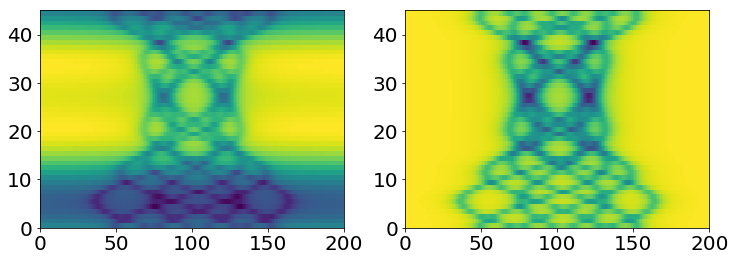

In [241]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].pcolor(img)
ax[1].pcolor(img_c)
# ax[0].pcolor()

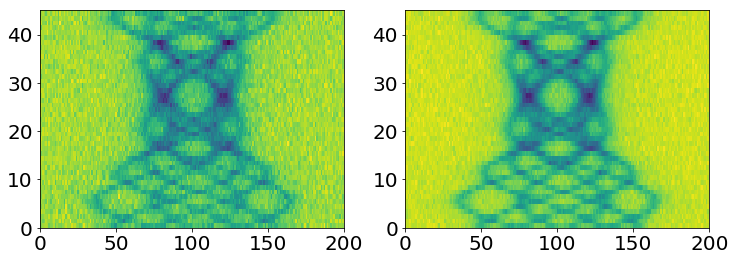

In [242]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
Z = img/img.max() + 0.002*np.random.randn(*img.shape)
Z=Z / np.tile(Z.mean(axis=1), (Z.shape[1],1)).T
Z_c = img_c/img_c.max() + 0.002*np.random.randn(*img_c.shape)
Z_c=Z_c / np.tile(Z_c.mean(axis=1), (Z_c.shape[1],1)).T
ax[0].pcolor(Z)
ax[1].pcolor(Z_c)


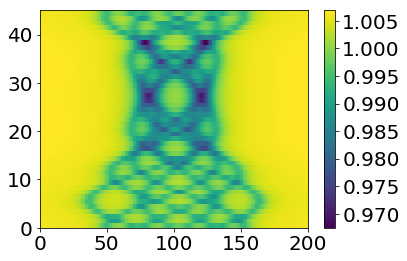

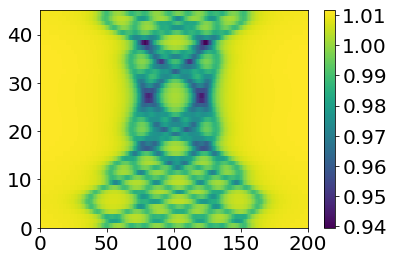

In [238]:
for Zo in [img, img_c]:

    Z=Zo / np.tile(Zo.mean(axis=1), (Zo.shape[1],1)).T
    plt.figure()
    plt.pcolor(Z)
    plt.colorbar()





## simple approach, find the best overlap - not finished!

In [243]:
combine_data=False  ## if true concatenate all the dataset with the same name and only differing last three digits



filename = 'sim_data_2_--type--_000'
tag = filename.split('_--type')[0].split('/')[-1]
# filename = path_data/filename
filename

'sim_data_2_--type--_000'

In [244]:
with open(path_data/(filename.replace('--type--', 'parameters')+'.json'), 'r') as infile:
    magnet_parameters =  json.load(infile)
magnet_parameters

{'particle_radius': [16, 8],
 'nv_radius': 72.433,
 'theta_mag': [45, 90],
 'phi_mag': [45, 90],
 'dipole_height': [55, 60],
 'shot_noise': 0,
 'linewidth': 14000000.0,
 'n_angle': 45,
 'n_freq': 200,
 'f_min': 2670000000.0,
 'f_max': 3068000000.0,
 'avrg_count_rate': 1,
 'xo': [0, 3],
 'yo': [0, 3]}

In [46]:
with open(path_data/(filename.replace('--type--', 'labels') + '.txt'),"r") as filein:
    labels = filein.read().split(',')
labels

['particle_radius', 'theta_mag', 'phi_mag', 'dipole_height', 'xo', 'yo']

In [61]:
if combine_data:
    train_set = None
    for f in path_data.glob( ('*'+ '_'.join((filename.replace('--type--', 'train')+'.h5').split('_')[0:-1]) +'*')):
        print(f)
        hf = h5py.File(f, 'r')
        
        if train_set is None:
            train_set = {k: np.array(hf.get(k)) for k in hf.keys()}
        else:
            train_set = {k: np.vstack([train_set[k], np.array(hf.get(k))]) for k in hf.keys()}
            
        hf.close()

else:
    f = path_data/(filename.replace('--type--', 'train')+'.h5')
    print(f)
    hf = h5py.File(f, 'r')
    train_set = {k: np.array(hf.get(k)) for k in hf.keys()}
    hf.close()



# hf = h5py.File(path_data/(filename.replace('--type--', 'train')+'.h5'), 'r')
# train_set = {k: np.array(hf.get(k)) for k in hf.keys()}
# hf.close()

../data/sim_data_2_train_000.h5


In [62]:
added_noise =  0.01
noise = added_noise*np.random.randn(*train_set['X'].shape)
X = train_set['X']+ noise
# X = esr_preprocessing(X, reference_level=1)  
# noise = added_noise*np.random.randn(*X.shape)
# X = X + noise
# X = esr_preprocessing(X, reference_level=1)

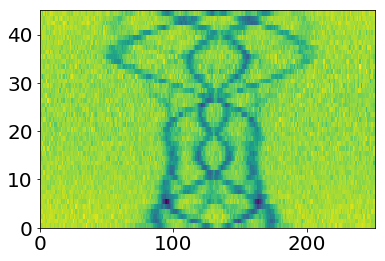

In [245]:
plt.pcolor(esr_map)

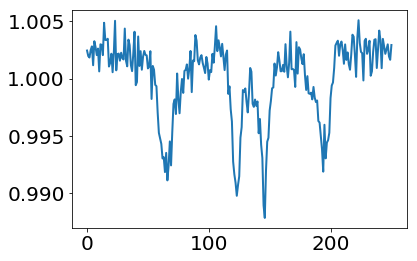

In [248]:
plt.plot(esr_map[38])

In [65]:
(X.max()-X.min())/added_noise

39.48767364146079

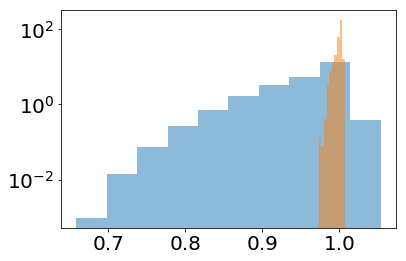

In [63]:
plt.hist(X.flatten(), log=True, density=True,alpha=0.5)
plt.hist(esr_map.flatten(), density=True, log=True,alpha=0.5);

In [130]:
added_noise = 0.005

X = train_set['X']
# noise = added_noise*np.random.randn(*X.shape)
# X = X + noise
X = 0.5+esr_preprocessing(X, reference_level='min_max')

In [131]:
X.shape,X.min(), X.max()

((10000, 45, 200), -0.002441, 1.002)

In [132]:
X_exp = 0.5+esr_preprocessing(np.expand_dims(esr_map[:,26:-25], 0), reference_level='min_max')

X_exp.shape, X_exp.min(), X_exp.max()

((1, 45, 200), 0.0, 1.0)

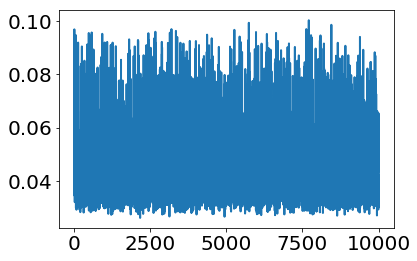

In [133]:
n= 10000
err = np.mean(np.reshape((np.repeat(X_exp,n, axis=0)-X[0:n])**2, (n, -1)), axis=1)

plt.plot(err)

In [134]:
err.argmin()

2167

In [135]:
esr_map[:,26:-25].max()

1.0062332152795714

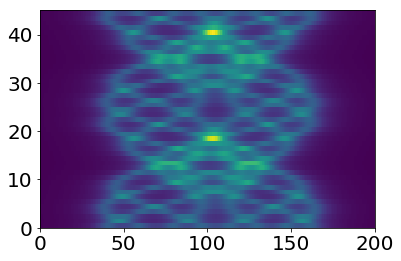

In [136]:
plt.pcolor(X[err.argmin()])

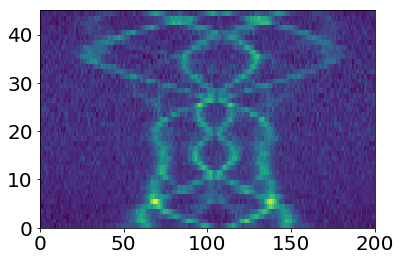

In [109]:
plt.pcolor(X_exp[0])

## testing the code - playing around

In [75]:
import pynvcenter.nv_optical_response as nv


# nv.esr_odmr_signal(f, co, c1, linewidth, fo, shot_noise=0)

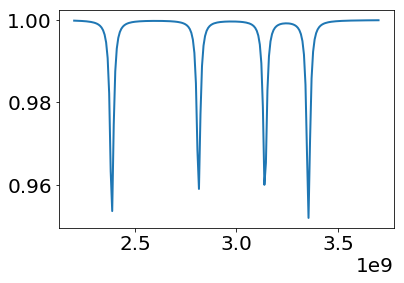

In [90]:
B_lab = np.expand_dims([0.01, 0.01,0.01], 0)
frequencies = np.linspace(2.2e9, 3.7e9, 201)
Dgs=2.87

avrg_count_rate = 1
linewidth = 10e6

contrast = nv.esr_contrast_ensemble(B_lab, k_MW=10, beta=1, gs=27.969, muB=1, hbar=1)#, Dgs=Dgs
esr_freq = nv.esr_frequencies_ensemble(B_lab)#, Dgs=Dgs

sig = nv.esr_odmr_signal_ensemble(
            frequencies,
            esr_freq.flatten(), contrast.flatten(),
            avrg_count_rate,
            linewidth=linewidth,
            shot_noise=0)
plt.plot(frequencies, sig)

In [83]:
contrast

array([[[2.96165563e-02, 2.36265430e-02],
        [2.96165563e-02, 2.36265430e-02],
        [2.96165563e-02, 2.36265430e-02],
        [2.37857200e+01, 2.37857200e+01]]])

In [84]:
nv.esr_contrast_ensemble(B_lab, k_MW=10, beta=1, gs=27.969, muB=1, hbar=1)#, Dgs=Dgs

array([[[6.06130487e+09, 1.01781124e+10],
        [6.06130487e+09, 1.01781124e+10],
        [6.06130487e+09, 1.01781124e+10],
        [1.97437290e+09, 9.68874581e+09]]])

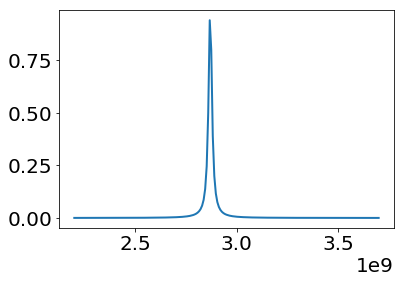

In [94]:
def lorenz(w, wo=2*np.pi*2.87e9, linewidth= 2*np.pi*10e6):
    return linewidth**2 / ( (w-wo)**2+linewidth**2 )

w = 2*np.pi*frequencies

plt.plot(frequencies, lorenz(w))

In [95]:
C = []
for i in range(4):
    # get the off axis and on axis field for NV_i
    BNV = B_fields_in_NV_frame(B_lab,i)
    
    Cm = photoluminescence_contrast(BNV, k12=k_MW, k13=0, beta=beta)
    C.append(Cm)

1.0

In [ ]:
def esr_contrast_ensemble_2(B_lab, k_MW=10, beta=1, gs=27.969, muB=1, hbar=1, Dgs=2.87):
    """
    calculates the esr contrast for the four NV families for a given magnetic field in the lab frame

    B_lab: magnetic field in the lab frame (N x 3) matrix
    k_MW: is the Rabi frequency applied to the ESR transition

    returns the esr contrast for all 4 NV families as M x N array, where
        M is the number of magnetic fields
        N = 4 is the number of NV families
    """

    C = []
    # get b field in cartesian coordinates

    for i in range(4):
        # get the off axis and on axis field for NV_i
        BNV = B_fields_in_NV_frame(B_lab,i)
        # calculate the ESR freq. for NV_i
        # we just calculate the maximum contrast for each of the two transitsion and sum them up
        # to get the spectrum, we just assume two Lorenzians
        # An alternative approach would be to assume that the MW freqs. follow a Lorenzian and calculate the photoluminescence contrast for each MW freq.
        Cm = photoluminescence_contrast(BNV, k12=k_MW, k13=0, beta=beta)
        Cp = photoluminescence_contrast(BNV, k12=0, k13=k_MW, beta=beta)

        C.append(np.vstack([Cm, Cp]).T)

    # rearrange so that we return a M x N x 2 array
    # M is the number of magnetic fields
    # N is the number of NV families
    return np.moveaxis(C, 0, 1)